In [1]:
# default_exp data.procs

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

In [101]:
from fastseq.data.all import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.all import *
from typing import List
import orjson

# Data.Procs

In [114]:
# export
class CatProc():
    def __init__(self, path, vocab = None, o2i = None):
        if vocab is None and o2i is None:
            vocab, o2i = make_vocab(path)
        self.meta = get_meta(path)
        self.f = CatMultiTfm(vocab = vocab, o2i = o2i)
        
    def setup(self, files:List[Path]):  
        r = []
        for f in files:
            r.append(self._setup(f))            
        return r
    
    def _setup(self, f:Path):   
        ts = get_ts_datapoint(f)
        tsm = json2TSMulti(ts, 0, self.meta['col_names']['ts_con_names'][0], ts['_length']-1, 1, self.meta)
        tsm = self.f(tsm)  
        for i, cat in enumerate(ts['ts_cat']):
            test_eq(len(tsm[2][i]), len(ts['ts_cat'][cat]))
            ts['ts_cat'][cat] = [o.item() for o in tsm[2][i]]
#         print(tsm)
        for i, cat in enumerate(ts['cat']):
            ts['cat'][cat] = tsm[3][i].item()
        open(f,'wb').write(orjson.dumps(dict(ts)))
        return r
        

In [116]:
path = Path('../data/test_data')
path.delete()
horizon,lookback = 7, 14
df = get_df([80, 80, 80])
path.mkdir()
save_df(df, path)
fs = get_files(path,extensions='.json',folders = False)

proc = CatProc(path)

r = proc.setup(fs)
for f in fs:
    ts = get_ts_datapoint(f)
    for cat in set(unpack_list([v for k,v in ts['ts_cat'].items()])):
        test_eq(type(cat), int)
        
    for cat in set(unpack_list([v for k,v in ts['cat'].items()])):
        test_eq(type(cat), int)

{'Train': 87, 'Val': 33}


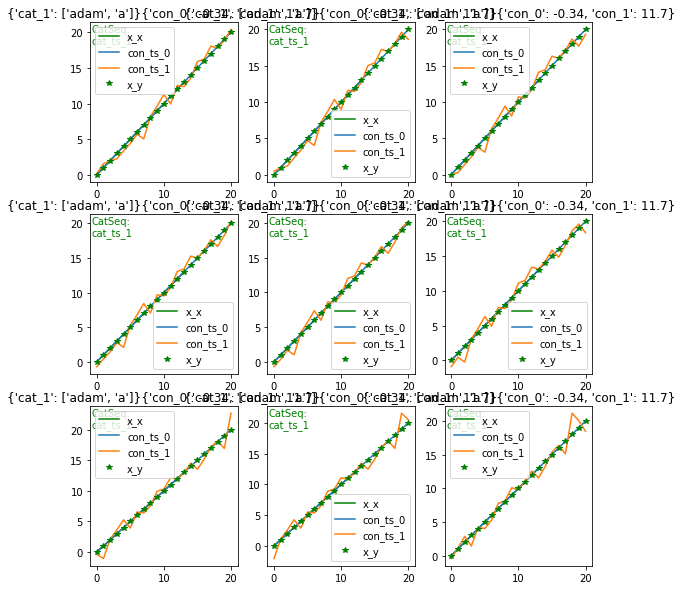

In [6]:
path = Path('../data/test_data')
path.delete()
horizon,lookback = 7, 14
df = get_df([80, 80, 80])
path.mkdir()
save_df(df, path)
dls = MTSDataLoaders.from_path(path, 'x', horizon=horizon, lookback=lookback, num_workers = 1)
dls.show_batch()

In [5]:
path = Path('../data/m5_tiny')
path.ls()

(#6) [Path('../data/m5_tiny/sales_train_validation.csv'),Path('../data/m5_tiny/sample_submission.csv'),Path('../data/m5_tiny/calendar.csv'),Path('../data/m5_tiny/prices.csv'),Path('../data/m5_tiny/rows'),Path('../data/m5_tiny/calender_d.csv')]

In [ ]:
%%time
for o in dl.train:
    
    pass

In [117]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_m5.ipynb.
Converted 04_data.procs.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_data.m5.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [118]:
git_add('04_data.procs.ipynb', commit_msg='CatProc')

Converted 04_data.procs.ipynb.


['/home/tako/dev/fastseq/fastseq/data/procs.py',
 '/home/tako/dev/fastseq/nbs/04_data.procs.ipynb']